### Modelo GEN
Las peliculas se codifican mediante su vector de generos de partida, de tal forma que solo podrá tener ceros y unos. 
lo que dotará al sistema de poca flexibilidad al hacer el producto escalar. En este caso, Los usuarios se codificaran por one hot y las peliculas se codificarán mediante el vector de generos a los que pertenecen

#### Resultados en el modelo 100K
El error médio absoluto obtenido las las semillas del notebook es 1.6898 muy cercano al del paper 1.6895

#### Pendiente:
Adaptar el codigo para el conjunto 25M

In [7]:
import pickle
import pandas as pd
from math import pi
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf

#garantizamos mismos resultados entre ejecuciones
import os
os.environ['PYTHONHASHSEED']='0'
rs = 1234  # Semilla aleatoria
np.random.seed(rs)
tf.random.set_seed(rs)

In [2]:
def save_to_pickle(name, item):
    filehandler = open(name+".pkl", "wb")
    pickle.dump(item, filehandler)
    filehandler.close()


def plot_metric(history, metric, valida):
    train_metrics = history.history[metric]
    # if valida:
    #    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    if valida:
        val_metrics = history.history['val_' + metric]
        plt.plot(epochs, val_metrics)
        plt.title('Training and validation ' + metric)
    else:
        plt.title('Training ' + metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    if valida:
        plt.legend(["train_"+metric, 'val_' + metric])
    plt.show()

In [3]:
def crear_modelo(K, LR, num_users, num_pelis, dim_users, dim_pelis, peso_score):
    user_input = tf.keras.layers.Input(shape=(dim_users,), name="input_usr")  # Variable-length sequence of ints
    usuarios_emb = tf.keras.layers.Embedding(input_dim=num_users, output_dim=K, name="embedding_usr")(user_input)
    usuarios = tf.keras.layers.Flatten(name="flatten_usr")(usuarios_emb)  # para pasar de (?,1,K) a (?,K)
    usr_emb_genr = tf.keras.layers.Dense(num_genres, activation='sigmoid', name="usr_dot")(usuarios)  # (?, num_genres)

    pelis_input = tf.keras.layers.Input(shape=(dim_pelis,), name="input_pelis")  # Variable-length sequence of ints
    # pelis_emb = tf.keras.layers.Embedding(input_dim=num_pelis, output_dim=K, name="embedding_pelis")(pelis_input)
    # pelis = tf.keras.layers.Flatten(name="flatten_pelis")(pelis_emb)  # para pasar de (?,1,K) a (?,K)
    # genre_pred = tf.keras.layers.Dense(num_genres, activation='sigmoid', name="genres")(pelis)  # (?, num_genres)

    score_pred = tf.keras.layers.Dot(axes=1, name="scores")([usr_emb_genr, pelis_input])

    model = tf.keras.Model(
        inputs=[user_input, pelis_input],
        outputs=[score_pred],
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(LR),
        # optimizer=keras.optimizers.RMSprop(1e-3),
        loss=tf.keras.losses.MeanSquaredError(),
        # loss_weights=[peso_score, 1 - peso_score],
        metrics=['mean_absolute_error'],  # tf.keras.metrics.BinaryAccuracy()],
    )

    model_usr = tf.keras.Model(
        inputs=[user_input],
        outputs=[usr_emb_genr],
    )

    '''model2.summary()
    output_array2 = model2.predict([valoraciones.user_id, valoraciones.item_id])
    print(output_array2.shape)'''

    return model, model_usr

In [4]:
def entrenar(VALIDATION, K, epochs, batch_size, learning_rate, peso_score, num_users, num_pelis, dim_input_users,
             dim_input_pelis, X_train, X_train_dev, X_test, y_train, y_train_dev, y_test):
    # SE CREA EL MODELO
    model, mod_usr = crear_modelo(K, learning_rate, num_users, num_pelis, dim_input_users, dim_input_pelis, peso_score)

    # ENTRENAMOS EL MODELO Y EVALUAMOS EN EL CONJUNTO DE TEST
    if VALIDATION:
        # DECLARAMOS UN OBJETO EARLY STOPPING PARA DECIDIR LA MEJOR EPOCH
        early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
        # early_stop = EarlyStopping(monitor='val_scores_loss', patience=20)

        checkpoint = tf.keras.callbacks.ModelCheckpoint('model/model_T_{epoch:06d}.h5', save_best_only=True)
        history = model.fit(x=[X_train.user_id, X_train[col_items]], y=[y_train],
                            validation_data=([X_dev.user_id, X_dev[col_items]], [y_dev]),
                            epochs=epochs, batch_size=batch_size, callbacks=[early_stop, checkpoint])
        print('Mejor epoch:', early_stop.stopped_epoch)
        media_en_train = y_train.mean()
    else:
        if epochs == 0:
            epochs = 1000
        checkpoint = tf.keras.callbacks.ModelCheckpoint('model/model_T+D_{epoch:06d}.h5')
        history = model.fit(x=[X_train_dev.user_id, X_train_dev[col_items]],
                            y=[y_train_dev],
                            epochs=epochs, batch_size=batch_size, callbacks=[checkpoint])
        media_en_train = y_train_dev.mean()
        usr_emb_g = mod_usr.predict([X_test.user_id])

    losses = model.evaluate([X_test.user_id, X_test[col_items]], [y_test])
    print('\t*-* Test                         loss: %.4f' % losses[0])
    print('\t*-* Test             MAE sobre scores: %.4f' % losses[1])

    prediction = model.predict([X_test.user_id, X_test[col_items]])
    print('Test MAE    modelo: %.4f' % (sum(abs(y_test - prediction.flatten())) / y_test.shape[0]))
    print('Test MAE Sys-Media: %.4f' % (sum(abs(y_test - media_en_train)) / y_test.shape[0]))

    # GRÁFICOS
    plot_metric(history, 'loss', valida=VALIDATION)
    plot_metric(history, 'mean_absolute_error', valida=VALIDATION)

    if VALIDATION:
        return model, early_stop.stopped_epoch
    else:
        return model, prediction, usr_emb_g




In [5]:
# ---------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------
# MAIN
# ---------------------------------------------------------------------------------------------------------------------

PATH = '/Users/antonio/OneDrive - farmasturias.org/DOCTORADO/paper_generos_peliculas/XAI_movies/cjtos/ml-100k/'

# ---------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------
# VALORACIONES
# ---------------------------------------------------------------------------------------------------------------------
valoraciones = pd.read_csv(PATH+'u.data', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
print(valoraciones)
# quito el timestamp porque no me interesa
valoraciones.drop(['timestamp'], axis='columns', inplace=True)
# de momento dejo el rating como un problema de regresión
print(valoraciones)

num_ejem = valoraciones.shape[0]
num_users = valoraciones.user_id.max()+1  # 943, del 1 al 943. El +1 es porque empieza en 0
num_pelis = valoraciones.item_id.max()+1  # 1682, del 1 al 1682

# ---------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------
# ITEMS (PELÍCULAS)
# ---------------------------------------------------------------------------------------------------------------------
items = pd.read_csv(PATH+'u.item', sep='|', names=['item_id', 'title', 'RD', 'VRD', 'IMDB', 'unknown', 'Action',
                                                   'Adventure', 'Animation', 'Children', 'Comedy', 'Crime',
                                                   'Documentary', 'Drama', 'Fantasy', 'FilmNoir', 'Horror', 'Musical',
                                                   'Mystery', 'Romance', 'SciFi', 'Thriller', 'War', 'Western'])
print(items)
# de las películas me quedo sólo con los géneros de las mismas. El resto de campos los elimino
# dejo el item_id para comprobaciones
# titles = items.loc[:, ['item_id', 'title']]
items.drop(['RD', 'VRD', 'IMDB', 'unknown'], axis='columns', inplace=True)
print(items)

num_genres = items.shape[1]-2  # el -2 es para no contar el item_id ni el título. Son 18 géneros


# ---------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------
# PREPARANDO EL CONJUNTO DE DATOS
# ---------------------------------------------------------------------------------------------------------------------
cjto = valoraciones

# añado las columnas para el item ceros
col_items = items.columns.drop(['item_id', 'title'])
# col_items = col_items.drop(['item_id', 'title'])
cjto[col_items] = np.zeros((cjto.shape[0], col_items.shape[0]), dtype='int32')

# relleno los items con sus valores
for i in range(items.shape[0]):
    num_item = items.iloc[i].item_id
    if i % 20 == 0:
        print("item:", num_item)
    cjto.loc[cjto.item_id == num_item, col_items] = items.iloc[i, 2:].to_list()  # se salta item_id y title

# X / y
X = cjto[['user_id', 'item_id'] + col_items.values.tolist()].copy()
y = cjto['rating'].copy()

TEST = 0.10
DEV = 0.10

# TRAIN/DEV/TEST SPLIT (sin estratificar para prevenir errores)
X_train_dev, X_test, y_train_dev, y_test = train_test_split(X, y, stratify=None, test_size=TEST, random_state=2032)
X_train, X_dev, y_train, y_dev = train_test_split(X_train_dev, y_train_dev, stratify=None,
                                                  test_size=DEV, random_state=2032)

print("% test =", TEST, "\n% dev =", DEV)
print("X_train:", X_train.shape)
print("X_dev  :", X_dev.shape)
print("X_test :", X_test.shape)
print("y_train:", y_train.shape)
print("y_dev  :", y_dev.shape)
print("y_test :", y_test.shape)



       user_id  item_id  rating  timestamp
0          196      242       3  881250949
1          186      302       3  891717742
2           22      377       1  878887116
3          244       51       2  880606923
4          166      346       1  886397596
...        ...      ...     ...        ...
99995      880      476       3  880175444
99996      716      204       5  879795543
99997      276     1090       1  874795795
99998       13      225       2  882399156
99999       12      203       3  879959583

[100000 rows x 4 columns]
       user_id  item_id  rating
0          196      242       3
1          186      302       3
2           22      377       1
3          244       51       2
4          166      346       1
...        ...      ...     ...
99995      880      476       3
99996      716      204       5
99997      276     1090       1
99998       13      225       2
99999       12      203       3

[100000 rows x 3 columns]
      item_id                                 

item: 1521
item: 1541
item: 1561
item: 1581
item: 1601
item: 1621
item: 1641
item: 1661
item: 1681
% test = 0.1 
% dev = 0.1
X_train: (81000, 20)
X_dev  : (9000, 20)
X_test : (10000, 20)
y_train: (81000,)
y_dev  : (9000,)
y_test : (10000,)


Epoch 1/1000
159/159 [==============================] - 0s 1ms/step - loss: 7.5557 - mean_absolute_error: 2.4910 - val_loss: 7.4398 - val_mean_absolute_error: 2.4680
Epoch 2/1000
159/159 [==============================] - 0s 743us/step - loss: 7.4924 - mean_absolute_error: 2.4772 - val_loss: 7.3477 - val_mean_absolute_error: 2.4502
Epoch 3/1000
159/159 [==============================] - 0s 753us/step - loss: 7.3970 - mean_absolute_error: 2.4596 - val_loss: 7.2286 - val_mean_absolute_error: 2.4270
Epoch 4/1000
159/159 [==============================] - 0s 955us/step - loss: 7.2197 - mean_absolute_error: 2.4245 - val_loss: 7.0796 - val_mean_absolute_error: 2.3973
Epoch 5/1000
159/159 [==============================] - 0s 949us/step - loss: 7.0906 - mean_absolute_error: 2.3979 - val_loss: 6.9009 - val_mean_absolute_error: 2.3610
Epoch 6/1000
159/159 [==============================] - 0s 898us/step - loss: 6.9448 - mean_absolute_error: 2.3686 - val_loss: 6.6967 - val_mean_absolute_error: 2

159/159 [==============================] - 0s 775us/step - loss: 4.1639 - mean_absolute_error: 1.7081 - val_loss: 4.1521 - val_mean_absolute_error: 1.6992
Epoch 50/1000
159/159 [==============================] - 0s 730us/step - loss: 4.2036 - mean_absolute_error: 1.7183 - val_loss: 4.1499 - val_mean_absolute_error: 1.6984
Epoch 51/1000
159/159 [==============================] - 0s 733us/step - loss: 4.1986 - mean_absolute_error: 1.7167 - val_loss: 4.1479 - val_mean_absolute_error: 1.6977
Epoch 52/1000
159/159 [==============================] - 0s 742us/step - loss: 4.1688 - mean_absolute_error: 1.7081 - val_loss: 4.1461 - val_mean_absolute_error: 1.6970
Epoch 53/1000
159/159 [==============================] - 0s 742us/step - loss: 4.1857 - mean_absolute_error: 1.7139 - val_loss: 4.1444 - val_mean_absolute_error: 1.6964
Epoch 54/1000
159/159 [==============================] - 0s 737us/step - loss: 4.1432 - mean_absolute_error: 1.7020 - val_loss: 4.1429 - val_mean_absolute_error: 1.6958


159/159 [==============================] - 0s 749us/step - loss: 4.1156 - mean_absolute_error: 1.6927 - val_loss: 4.1237 - val_mean_absolute_error: 1.6889
Epoch 98/1000
159/159 [==============================] - 0s 733us/step - loss: 4.1538 - mean_absolute_error: 1.7020 - val_loss: 4.1235 - val_mean_absolute_error: 1.6888
Epoch 99/1000
159/159 [==============================] - 0s 778us/step - loss: 4.1200 - mean_absolute_error: 1.6953 - val_loss: 4.1234 - val_mean_absolute_error: 1.6888
Epoch 100/1000
159/159 [==============================] - 0s 738us/step - loss: 4.1343 - mean_absolute_error: 1.6953 - val_loss: 4.1233 - val_mean_absolute_error: 1.6888
Epoch 101/1000
159/159 [==============================] - 0s 735us/step - loss: 4.1483 - mean_absolute_error: 1.6997 - val_loss: 4.1232 - val_mean_absolute_error: 1.6888
Epoch 102/1000
159/159 [==============================] - 0s 742us/step - loss: 4.1455 - mean_absolute_error: 1.6993 - val_loss: 4.1230 - val_mean_absolute_error: 1.68

159/159 [==============================] - 0s 770us/step - loss: 4.1732 - mean_absolute_error: 1.7043 - val_loss: 4.1196 - val_mean_absolute_error: 1.6883
Epoch 146/1000
159/159 [==============================] - 0s 741us/step - loss: 4.1679 - mean_absolute_error: 1.7034 - val_loss: 4.1195 - val_mean_absolute_error: 1.6883
Epoch 147/1000
159/159 [==============================] - 0s 738us/step - loss: 4.1407 - mean_absolute_error: 1.6976 - val_loss: 4.1195 - val_mean_absolute_error: 1.6883
Epoch 148/1000
159/159 [==============================] - 0s 730us/step - loss: 4.1409 - mean_absolute_error: 1.6992 - val_loss: 4.1195 - val_mean_absolute_error: 1.6883
Epoch 149/1000
159/159 [==============================] - 0s 776us/step - loss: 4.1415 - mean_absolute_error: 1.6981 - val_loss: 4.1195 - val_mean_absolute_error: 1.6883
Epoch 150/1000
159/159 [==============================] - 0s 753us/step - loss: 4.1505 - mean_absolute_error: 1.6992 - val_loss: 4.1195 - val_mean_absolute_error: 1.

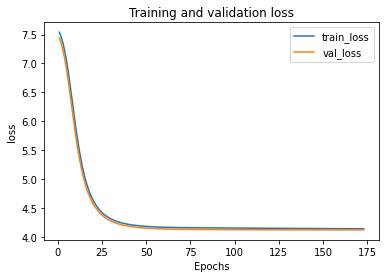

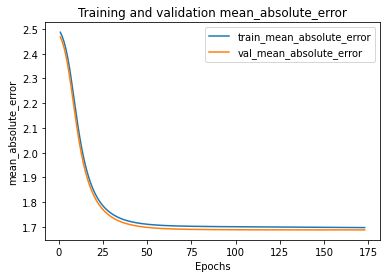

Epoch 1/172
176/176 [==============================] - 0s 648us/step - loss: 7.5428 - mean_absolute_error: 2.4895
Epoch 2/172
176/176 [==============================] - 0s 625us/step - loss: 7.4467 - mean_absolute_error: 2.4672
Epoch 3/172
176/176 [==============================] - 0s 615us/step - loss: 7.2960 - mean_absolute_error: 2.4381
Epoch 4/172
176/176 [==============================] - 0s 610us/step - loss: 7.1329 - mean_absolute_error: 2.4075
Epoch 5/172
176/176 [==============================] - 0s 617us/step - loss: 6.9495 - mean_absolute_error: 2.3709
Epoch 6/172
176/176 [==============================] - 0s 619us/step - loss: 6.6751 - mean_absolute_error: 2.3133
Epoch 7/172
176/176 [==============================] - 0s 619us/step - loss: 6.4484 - mean_absolute_error: 2.2640
Epoch 8/172
176/176 [==============================] - 0s 628us/step - loss: 6.1689 - mean_absolute_error: 2.2046
Epoch 9/172
176/176 [==============================] - 0s 633us/step - loss: 5.9055 - me

176/176 [==============================] - 0s 635us/step - loss: 4.1495 - mean_absolute_error: 1.7007
Epoch 73/172
176/176 [==============================] - 0s 614us/step - loss: 4.1744 - mean_absolute_error: 1.7076
Epoch 74/172
176/176 [==============================] - 0s 610us/step - loss: 4.1877 - mean_absolute_error: 1.7075
Epoch 75/172
176/176 [==============================] - 0s 612us/step - loss: 4.1367 - mean_absolute_error: 1.6963
Epoch 76/172
176/176 [==============================] - 0s 610us/step - loss: 4.1473 - mean_absolute_error: 1.6989
Epoch 77/172
176/176 [==============================] - 0s 634us/step - loss: 4.1711 - mean_absolute_error: 1.7044
Epoch 78/172
176/176 [==============================] - 0s 627us/step - loss: 4.1495 - mean_absolute_error: 1.6999
Epoch 79/172
176/176 [==============================] - 0s 617us/step - loss: 4.1526 - mean_absolute_error: 1.6998
Epoch 80/172
176/176 [==============================] - 0s 615us/step - loss: 4.1669 - mean_a

Epoch 143/172
176/176 [==============================] - 0s 627us/step - loss: 4.1595 - mean_absolute_error: 1.7017
Epoch 144/172
176/176 [==============================] - 0s 629us/step - loss: 4.1225 - mean_absolute_error: 1.6927
Epoch 145/172
176/176 [==============================] - 0s 627us/step - loss: 4.1358 - mean_absolute_error: 1.6945
Epoch 146/172
176/176 [==============================] - 0s 627us/step - loss: 4.1451 - mean_absolute_error: 1.6986
Epoch 147/172
176/176 [==============================] - 0s 623us/step - loss: 4.1306 - mean_absolute_error: 1.6923
Epoch 148/172
176/176 [==============================] - 0s 622us/step - loss: 4.1277 - mean_absolute_error: 1.6948
Epoch 149/172
176/176 [==============================] - 0s 613us/step - loss: 4.1475 - mean_absolute_error: 1.6993
Epoch 150/172
176/176 [==============================] - 0s 614us/step - loss: 4.1512 - mean_absolute_error: 1.7001
Epoch 151/172
176/176 [==============================] - 0s 678us/step -

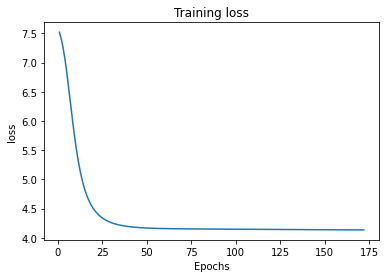

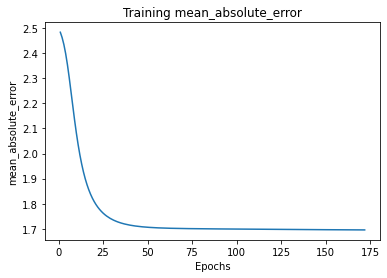

hiperparámetros: K=32, batch_size=512, learning_rate=0.000100, peso_score=0.50
FIN


In [8]:
# ---------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------
# ENTRENAMIENTO
# ---------------------------------------------------------------------------------------------------------------------
K = 32  # 32
learning_rate = 1e-4
dim_input_users = 1  # el entero a partir del cual se calcula el embedding
dim_input_pelis = 18  # el vector con los géneros de la película
tam_batch = 512
max_epochs = 1000
peso_score = 0.5  # NO SE APLICA

# ---------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------
# TRAIN -> DEV Y TEST
# ---------------------------------------------------------------------------------------------------------------------
VALIDATION = True
model, n_epochs = entrenar(VALIDATION, K, max_epochs, tam_batch, learning_rate, peso_score, num_users, num_pelis,
                           dim_input_users, dim_input_pelis, X_train, X_train_dev, X_test, y_train, y_train_dev, y_test)

# ---------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------
# TRAIN+DEV -> TEST
# ---------------------------------------------------------------------------------------------------------------------
VALIDATION = False
model, prediction, usr_emb_genres = entrenar(VALIDATION, K, n_epochs, tam_batch, learning_rate, peso_score, num_users,
                                        num_pelis, dim_input_users, dim_input_pelis,
                                        X_train, X_train_dev, X_test, y_train, y_train_dev, y_test)


# ---------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------

print('hiperparámetros: K=%d, batch_size=%d, learning_rate=%f, peso_score=%.2f' % (K, tam_batch, learning_rate,
                                                                                   peso_score))
print("FIN")